In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import unireps
import torch
import datasets
import matplotlib.pyplot as plt
from tqdm import tqdm

# project_dir = '/Users/christopher/Documents/unireps'
project_dir = '/net/scratch2/chriswolfram/unireps'
unireps.set_hf_cache_directory(os.path.join(project_dir, 'hf_cache'))
unireps.set_datasets_directory(os.path.join(project_dir, 'datasets'))
unireps.set_outputs_directory(os.path.join(project_dir, 'outputs'))

datasets.disable_caching()

### Models

In [2]:
model_names = [
    "openai-community/gpt2",
    "google/gemma-2b",
    "google/gemma-7b",
    "google/gemma-2-2b",
    "google/gemma-2-9b",
    "google/gemma-2-9b-it",
    "google/gemma-2-27b",
    "meta-llama/Meta-Llama-3.1-8B",
    "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "meta-llama/Llama-3.2-1B",
    "meta-llama/Llama-3.2-3B",
    "meta-llama/Llama-3.2-3B-Instruct",
    "meta-llama/Llama-3.2-11B-Vision",
    "mistralai/Mistral-7B-v0.3",
    "mistralai/Mistral-Nemo-Base-2407",
    "mistralai/Mixtral-8x7B-v0.1",
    "microsoft/Phi-3-mini-4k-instruct",
    "microsoft/Phi-3-medium-4k-instruct",
    "microsoft/Phi-3.5-mini-instruct",
    "tiiuae/falcon-40b",
    "tiiuae/falcon-11B",
    "meta-llama/Llama-3.1-70B",
    "meta-llama/Llama-3.1-70B-Instruct",
    "meta-llama/Llama-3.3-70B-Instruct",
    "tiiuae/falcon-mamba-7b"
]

chat_models = [
    "google/gemma-2-9b-it",
    "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "meta-llama/Llama-3.2-3B-Instruct",
    "microsoft/Phi-3-mini-4k-instruct",
    "microsoft/Phi-3-medium-4k-instruct",
    "microsoft/Phi-3.5-mini-instruct",
    "meta-llama/Llama-3.1-70B-Instruct",
    "meta-llama/Llama-3.3-70B-Instruct"
]

dataset_names = [
    "web_text",
    "web_text_caesar",
    "imdb",
    "random_strings",
    "book_translations_en",
    "book_translations_de",
    "common_words"
]

### Scatter plots

In [4]:
def model_dataset_gram(model, dataset, use_chat_template=False, layer=None, normalize=True, agg='last', n=1024):
    ds = unireps.get_dataset(model, dataset, use_chat_template=use_chat_template).take(n)
    embs = unireps.dataset_embs(ds, layer=layer, agg=agg, normalize=normalize)
    
    if layer is None:
        gram = embs @ embs.permute(0,2,1)
    else:
        gram = embs @ embs.T
    
    return gram

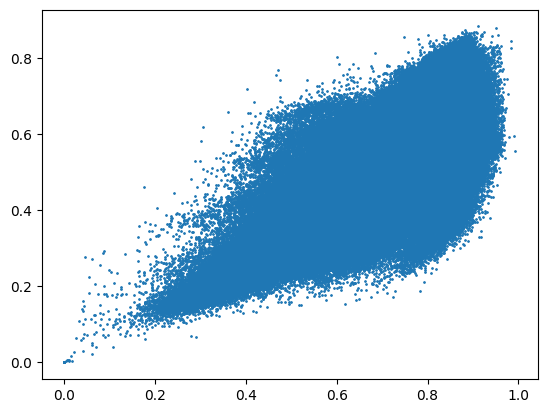

In [125]:
plt.scatter(
    1-model_dataset_gram("meta-llama/Meta-Llama-3.1-8B", 'web_text', layer=-5).flatten(),
    1-model_dataset_gram("google/gemma-2-9b", 'web_text', layer=-5).flatten(),
    s=0.5
)
plt.show()

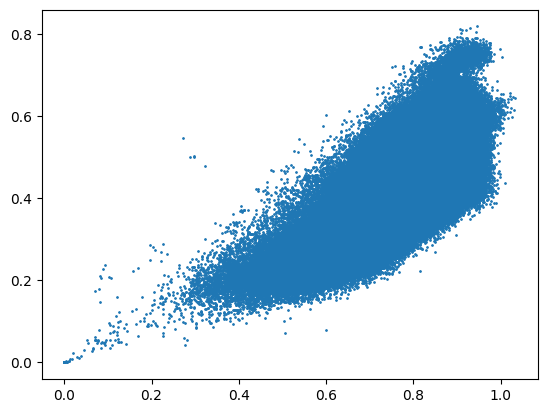

In [126]:
plt.scatter(
    1-model_dataset_gram("meta-llama/Meta-Llama-3.1-8B", 'web_text', layer=10).flatten(),
    1-model_dataset_gram("google/gemma-2-9b", 'web_text', layer=25).flatten(),
    s=0.5
)
plt.show()

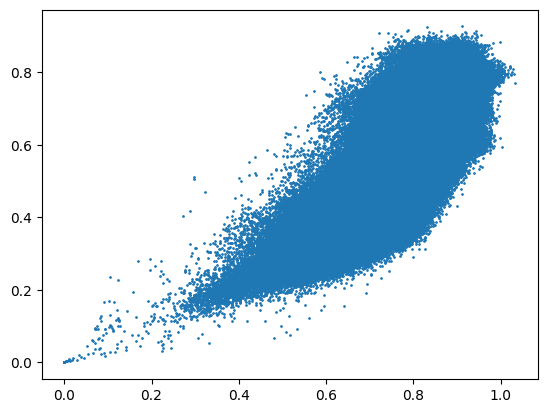

In [127]:
plt.scatter(
    1-model_dataset_gram("meta-llama/Meta-Llama-3.1-8B", 'web_text', layer=10).flatten(),
    1-model_dataset_gram("google/gemma-2-9b", 'web_text', layer=10).flatten(),
    s=0.5
)
plt.show()

### Layer similarity matrices

In [5]:
def model_dataset_knn(model, dataset, use_chat_template=False, normalize=True, agg='last', k=10, n=None):
    ds = unireps.get_dataset(model, dataset, use_chat_template=use_chat_template)

    if n is not None:
        ds = ds.take(n)

    knn = unireps.embs_knn(unireps.dataset_embs(ds, layer=None, agg=agg, normalize=normalize), k=k)
    return knn

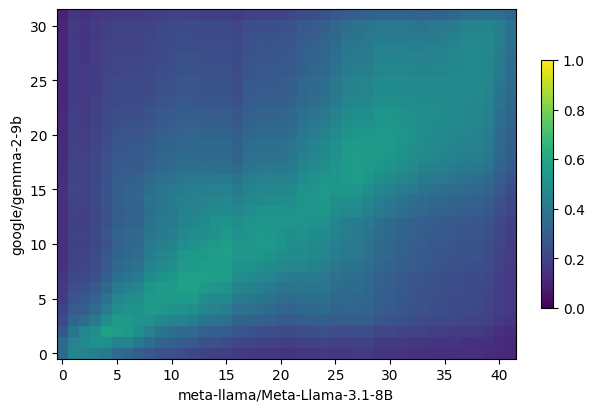

In [5]:
knn_1 = model_dataset_knn("meta-llama/Meta-Llama-3.1-8B", "web_text")
knn_2 = model_dataset_knn("google/gemma-2-9b", "web_text")
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn[1:,1:], x_label="google/gemma-2-9b", y_label="meta-llama/Meta-Llama-3.1-8B")
plt.show()

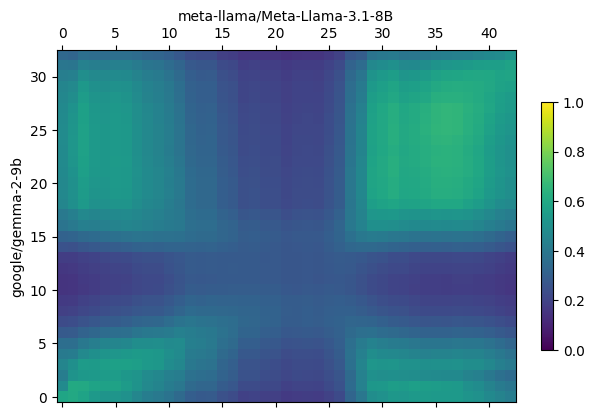

In [9]:
knn_1 = model_dataset_knn("meta-llama/Meta-Llama-3.1-8B", "random_strings")
knn_2 = model_dataset_knn("google/gemma-2-9b", "random_strings")
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn[1:,1:], x_label="google/gemma-2-9b", y_label="meta-llama/Meta-Llama-3.1-8B")
plt.show()

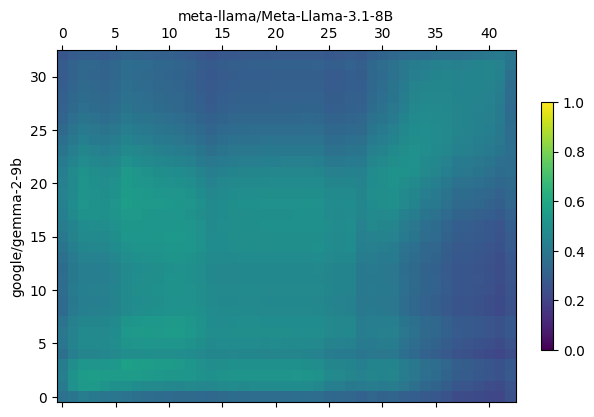

In [8]:
knn_1 = model_dataset_knn("meta-llama/Meta-Llama-3.1-8B", "common_words")
knn_2 = model_dataset_knn("google/gemma-2-9b", "common_words")
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn[1:,1:], x_label="google/gemma-2-9b", y_label="meta-llama/Meta-Llama-3.1-8B")
plt.show()

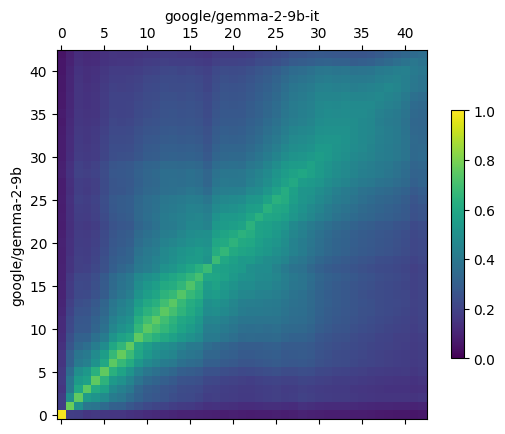

In [6]:
knn_1 = model_dataset_knn("google/gemma-2-9b", "web_text")
knn_2 = model_dataset_knn("google/gemma-2-9b-it", "web_text")
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn[1:,1:], x_label="google/gemma-2-9b", y_label="google/gemma-2-9b-it")
plt.show()

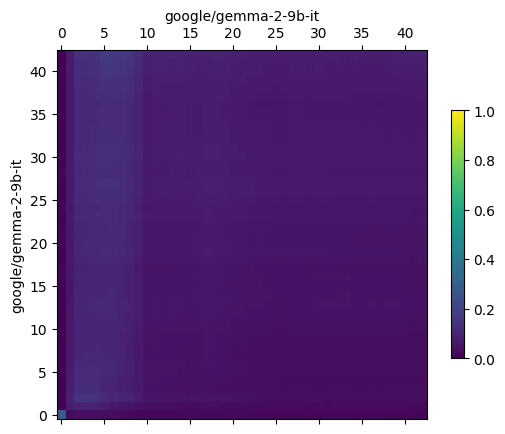

In [10]:
knn_1 = model_dataset_knn("google/gemma-2-9b-it", "web_text")
knn_2 = model_dataset_knn("google/gemma-2-9b-it", "web_text", use_chat_template=True)
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn[1:,1:], x_label="google/gemma-2-9b-it", y_label="google/gemma-2-9b-it")
plt.show()

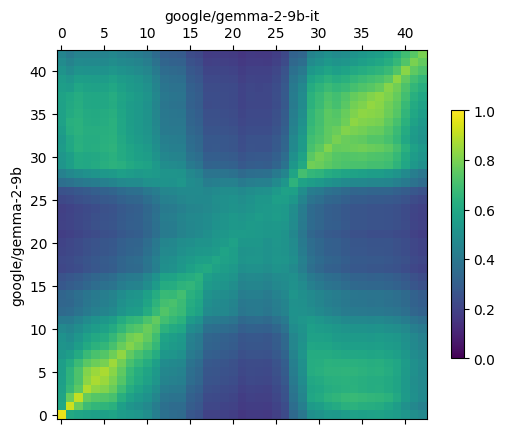

In [5]:
knn_1 = model_dataset_knn("google/gemma-2-9b", "random_strings")
knn_2 = model_dataset_knn("google/gemma-2-9b-it", "random_strings")
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn[1:,1:], x_label="google/gemma-2-9b", y_label="google/gemma-2-9b-it")
plt.show()

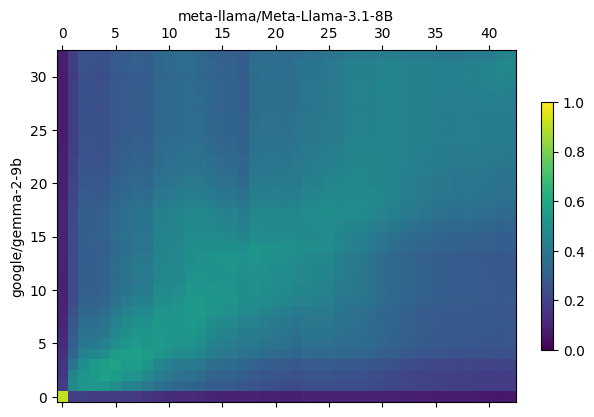

In [4]:
knn_1 = model_dataset_knn("meta-llama/Meta-Llama-3.1-8B", "mmlu")
knn_2 = model_dataset_knn("google/gemma-2-9b", "mmlu")
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn[1:,1:], x_label="google/gemma-2-9b", y_label="meta-llama/Meta-Llama-3.1-8B")
plt.show()

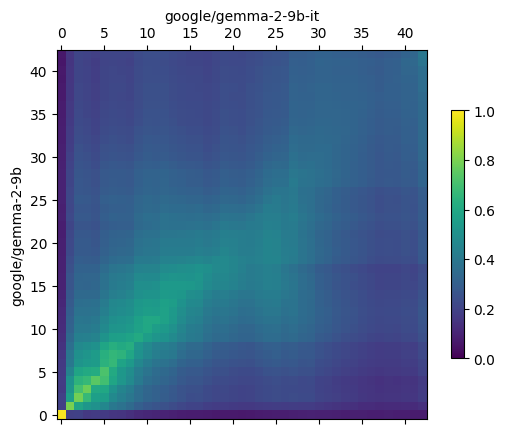

In [5]:
knn_1 = model_dataset_knn("google/gemma-2-9b", "mmlu")
knn_2 = model_dataset_knn("google/gemma-2-9b-it", "mmlu")
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn[1:,1:], x_label="google/gemma-2-9b", y_label="google/gemma-2-9b-it")
plt.show()

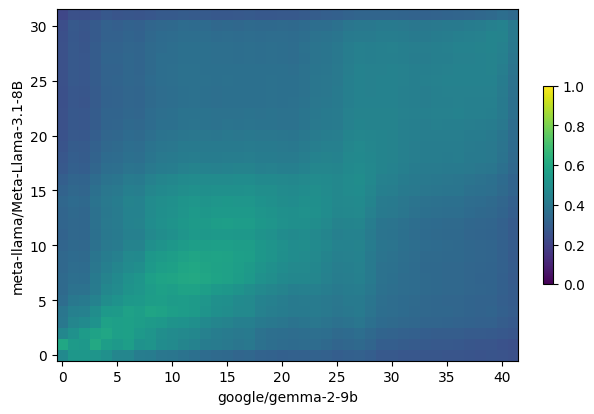

In [8]:
knn_1 = model_dataset_knn("meta-llama/Meta-Llama-3.1-8B", "ifeval")
knn_2 = model_dataset_knn("google/gemma-2-9b", "ifeval")
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn[1:,1:], x_label="google/gemma-2-9b", y_label="meta-llama/Meta-Llama-3.1-8B")
plt.show()

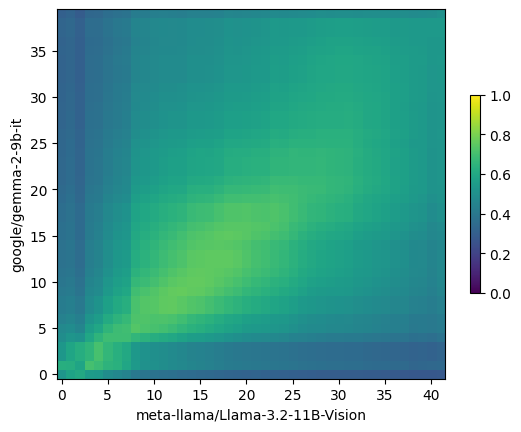

In [6]:
knn_1 = model_dataset_knn("meta-llama/Llama-3.2-11B-Vision", "ifeval")
knn_2 = model_dataset_knn("google/gemma-2-9b-it", "ifeval")
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn[1:,1:], x_label="meta-llama/Llama-3.2-11B-Vision", y_label="google/gemma-2-9b-it")
plt.show()

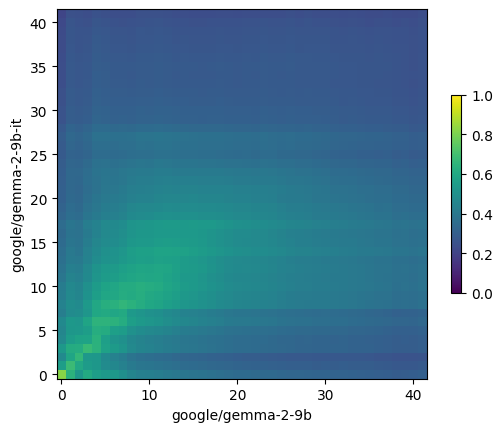

In [7]:
knn_1 = model_dataset_knn("google/gemma-2-9b", "ifeval")
knn_2 = model_dataset_knn("google/gemma-2-9b-it", "ifeval")
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn[1:,1:], x_label="google/gemma-2-9b", y_label="google/gemma-2-9b-it")
plt.show()

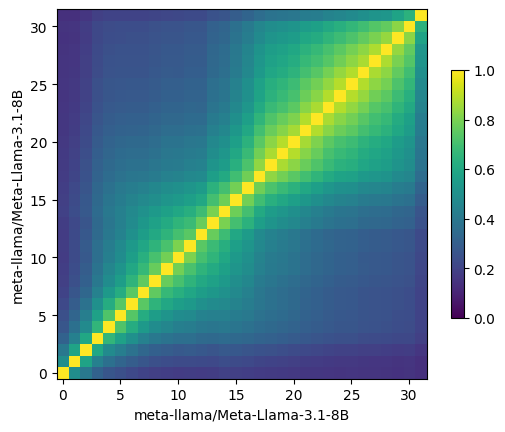

In [10]:
knn_1 = model_dataset_knn("meta-llama/Meta-Llama-3.1-8B", "web_text")
mknn = unireps.mutual_knn(knn_1, knn_1)
unireps.layer_by_layer_plot(mknn[1:,1:], x_label="meta-llama/Meta-Llama-3.1-8B", y_label="meta-llama/Meta-Llama-3.1-8B")
plt.show()

#### CKA

In [ ]:
def rv(emb_1, emb_2):
    

In [ ]:
knn_1 = model_dataset_knn("google/gemma-2-9b", "web_text")
knn_2 = model_dataset_knn("google/gemma-2-9b-it", "web_text")
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn, model_1="google/gemma-2-9b", model_2="google/gemma-2-9b-it")
plt.show()

### Model-by-model comparisons

In [22]:
def model_similarities(models, dataset, layers, use_chat_template=False, normalize=True, agg='last', k=10, n=1024):
    if isinstance(layers, int):
        layers = [layers for _ in range(len(models))]

    model_knns = []
    for model, layer in zip(tqdm(models), layers):
        ds = unireps.get_dataset(model, dataset, use_chat_template=use_chat_template).take(n)
        knn = unireps.embs_knn(unireps.dataset_embs(ds, layer=layer, agg=agg, normalize=normalize), k=k)
        model_knns.append(knn)
    
    out = torch.zeros(len(models), len(models))
    for i in tqdm(range(len(models))):
        for j in range(len(models)):
            out[i,j] = unireps.mutual_knn(model_knns[i], model_knns[j])

    return out

In [23]:
models = model_names

model_sims = model_similarities(models, 'web_text', 5)

 76%|███████▌  | 19/25 [01:47<00:49,  8.26s/it]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

 84%|████████▍ | 21/25 [02:29<00:57, 14.34s/it]

Loading dataset from disk:   0%|          | 0/22 [00:00<?, ?it/s]

 88%|████████▊ | 22/25 [03:01<00:58, 19.62s/it]

Loading dataset from disk:   0%|          | 0/22 [00:00<?, ?it/s]

 92%|█████████▏| 23/25 [03:35<00:48, 24.11s/it]

Loading dataset from disk:   0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:10<00:00,  2.33it/s]


In [33]:
model_sims_late = model_similarities(models, 'web_text', -5)

 76%|███████▌  | 19/25 [00:43<00:16,  2.71s/it]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

 84%|████████▍ | 21/25 [00:54<00:16,  4.14s/it]

Loading dataset from disk:   0%|          | 0/22 [00:00<?, ?it/s]

 88%|████████▊ | 22/25 [01:01<00:15,  5.07s/it]

Loading dataset from disk:   0%|          | 0/22 [00:00<?, ?it/s]

 92%|█████████▏| 23/25 [01:10<00:12,  6.14s/it]

Loading dataset from disk:   0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:10<00:00,  2.32it/s]


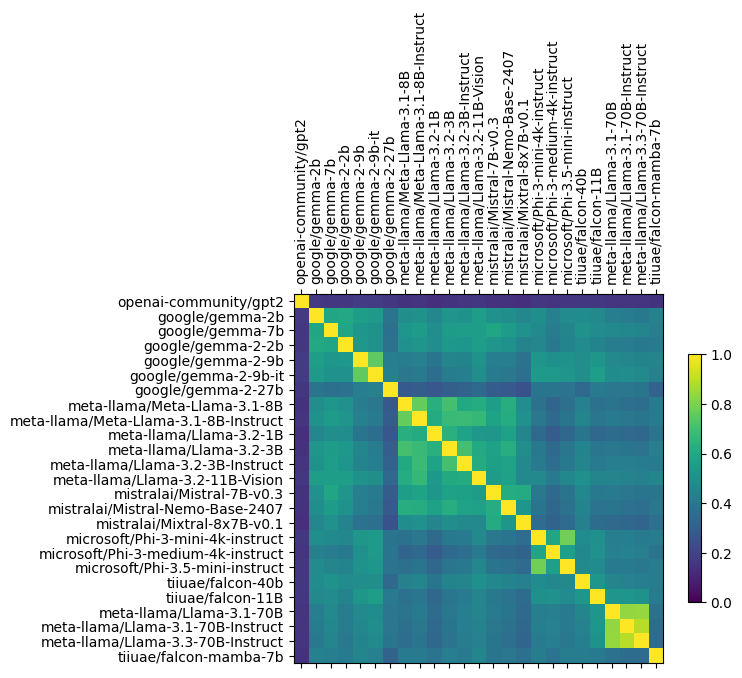

In [32]:
fig = plt.figure()
ax = fig.add_subplot()

cax = ax.matshow(model_sims, vmin=0, vmax=1)
fig.colorbar(cax, fraction=0.025)

ax.set_xticks(range(len(models)), )
ax.set_yticks(range(len(models)))
ax.set_xticklabels(models)
ax.set_yticklabels(models)

plt.xticks(rotation=90)
plt.show()

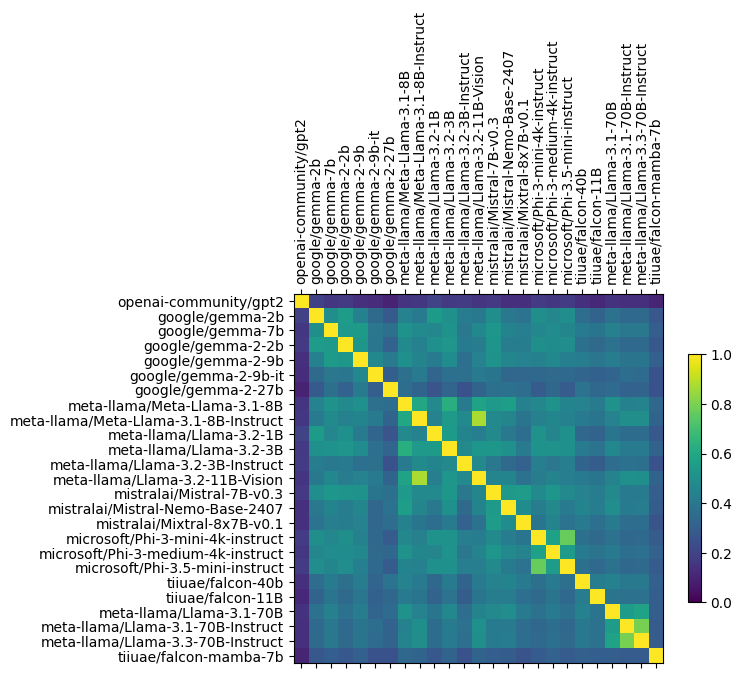

In [34]:
fig = plt.figure()
ax = fig.add_subplot()

cax = ax.matshow(model_sims_late, vmin=0, vmax=1)
fig.colorbar(cax, fraction=0.025)

ax.set_xticks(range(len(models)), )
ax.set_yticks(range(len(models)))
ax.set_xticklabels(models)
ax.set_yticklabels(models)

plt.xticks(rotation=90)
plt.show()

## Scratch space

### Big matrices

In [6]:
import pickle
import numpy as np
knn_dir = os.path.join(project_dir, 'knn')
fig_cache_dir = '../figure_cache'

def get_knn_path(model, dataset, use_chat_template=False):
        return os.path.join(knn_dir, unireps.get_dataset_name(model, dataset, use_chat_template=use_chat_template)) + '.parquet'

def get_layer_knn(model, dataset, use_chat_template=False, k=10):
    ds = datasets.Dataset.from_parquet(get_knn_path(model, dataset, use_chat_template=use_chat_template))
    ds.set_format('torch')
    return ds['knn'][:,:,:k].permute(1,0,2)

def generate_all_mknn(model_names, dataset_name):
    model_knns = {}
    for m in tqdm(model_names):
        model_knns[m] = get_layer_knn(m, dataset_name)

    model_model_mknn = {}
    for i in tqdm(range(len(model_names))):
        for j in range(i+1):
            m1 = model_names[i]
            m2 = model_names[j]
            knn_1 = model_knns[m1]
            knn_2 = model_knns[m2]
            mknn = unireps.mutual_knn(knn_1, knn_2)

            model_model_mknn[(m1,m2)] = mknn

    return model_model_mknn

def generate_all_mknn_cached(path, model_names, dataset_name):
    if os.path.exists(path):
        with open(path, 'rb') as f:
            mknns = pickle.load(f)
    else:
        mknns = generate_all_mknn(model_names, dataset_name)
        with open(path, 'wb') as f:
            pickle.dump(mknns, f)

    return mknns

def get_from_all_mknn(mknns, m1, m2):
    if (m1,m2) in mknns:
        return mknns[(m1,m2)][1:,1:]
    else:
        return mknns[(m2,m1)][1:,1:].T

In [95]:
dataset = 'web_text'
mat_model_names = [
    "google/gemma-2-9b",
    "meta-llama/Meta-Llama-3.1-8B"
]

In [114]:
mat_model_names = [
    # "openai-community/gpt2",
    "google/gemma-2b",
    "google/gemma-7b",
    "google/gemma-2-2b",
    "google/gemma-2-9b",
    # "google/gemma-2-9b-it",
    "google/gemma-2-27b",
    "meta-llama/Meta-Llama-3.1-8B",
    # "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "meta-llama/Llama-3.2-1B",
    "meta-llama/Llama-3.2-3B",
    # "meta-llama/Llama-3.2-3B-Instruct",
    "meta-llama/Llama-3.2-11B-Vision",
    "meta-llama/Llama-3.1-70B",
    # "meta-llama/Llama-3.1-70B-Instruct",
    # "meta-llama/Llama-3.3-70B-Instruct",
    "mistralai/Mistral-7B-v0.3",
    "mistralai/Mistral-Nemo-Base-2407",
    "mistralai/Mixtral-8x7B-v0.1",
    # "microsoft/Phi-3-mini-4k-instruct",
    # "microsoft/Phi-3-medium-4k-instruct",
    # "microsoft/Phi-3.5-mini-instruct",
    "tiiuae/falcon-40b",
    "tiiuae/falcon-11B",
    # "tiiuae/falcon-mamba-7b"
]

In [108]:
mat_model_names = [
    # "openai-community/gpt2",
    # "google/gemma-2b",
    # "google/gemma-7b",
    # "google/gemma-2-2b",
    "google/gemma-2-9b",
    # "google/gemma-2-9b-it",
    "google/gemma-2-27b",
    "meta-llama/Meta-Llama-3.1-8B",
    # "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "meta-llama/Llama-3.2-1B",
    "meta-llama/Llama-3.2-3B",
    # "meta-llama/Llama-3.2-3B-Instruct",
    # "meta-llama/Llama-3.2-11B-Vision",
    "meta-llama/Llama-3.1-70B",
    # "meta-llama/Llama-3.1-70B-Instruct",
    # "meta-llama/Llama-3.3-70B-Instruct",
    "mistralai/Mistral-7B-v0.3",
    # "mistralai/Mistral-Nemo-Base-2407",
    # "mistralai/Mixtral-8x7B-v0.1",
    # "microsoft/Phi-3-mini-4k-instruct",
    # "microsoft/Phi-3-medium-4k-instruct",
    # "microsoft/Phi-3.5-mini-instruct",
    # "tiiuae/falcon-40b",
    # "tiiuae/falcon-11B",
    # "tiiuae/falcon-mamba-7b"
]

In [7]:
mknn_path = os.path.join(fig_cache_dir, 'mknn_{}.pickle'.format(dataset))
mknns = generate_all_mknn_cached(mknn_path, model_names, dataset)

In [ ]:
def save_big_mat(path, mat_model_names, mknns):
    big_mat = torch.cat([torch.cat([get_from_all_mknn(mknns, m1, m2).T for m2 in mat_model_names]).T for m1 in mat_model_names])
    model_layers = np.array([get_from_all_mknn(mknns, m, mat_model_names[0]).shape[0] for m in mat_model_names])
    tick_positions = model_layers.cumsum()
    tick_positions = np.insert(tick_positions, 0, 0)
    tick_positions = (tick_positions[1:] + tick_positions[:-1])/2

    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot()

    cax = ax.imshow(big_mat, vmin=0, vmax=1, interpolation="nearest", aspect='equal')
    # fig.colorbar(cax, fraction=0.02)

    ax.xaxis.set_tick_params(rotation=90)

    ax.xaxis.set_ticks(tick_positions, mat_model_names)
    ax.yaxis.set_ticks(tick_positions, mat_model_names)

    ax.invert_yaxis()

    plt.tight_layout()
    plt.savefig(path, transparent=True, format='pdf')

In [133]:
def big_mat_plot(mknns, mat_model_names, tick_spacing=10, invert_yaxis=False, rotate_model_names=True, figsize=(10,10)):
    big_mat = torch.cat([torch.cat([get_from_all_mknn(mknns, m1, m2).T for m2 in mat_model_names]).T for m1 in mat_model_names])
    big_mat = np.ma.array(big_mat, mask=np.tri(big_mat.shape[0], big_mat.shape[1], k=0).T)

    model_layers = np.array([get_from_all_mknn(mknns, m, mat_model_names[0]).shape[0] for m in mat_model_names])

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()

    cax = ax.imshow(big_mat, vmin=0, vmax=1, interpolation="nearest", aspect='equal')
    # fig.colorbar(cax, fraction=0.02)

    # Layer ticks
    tick_positions = np.array([])
    tick_labels = np.array([], dtype=np.int64)
    depth = 0
    for d in model_layers:
        tick_positions = np.concatenate((tick_positions, np.arange(tick_spacing, d, tick_spacing) + depth))
        tick_labels = np.concatenate((tick_labels, np.arange(tick_spacing, d, tick_spacing)))
        depth += d

    ax.xaxis.set_ticks(tick_positions, tick_labels)
    ax.yaxis.set_ticks(tick_positions, tick_labels)

    # Model ticks
    model_tick_positions = model_layers.cumsum()
    model_tick_positions = np.insert(model_tick_positions, 0, 0)
    model_tick_positions = (model_tick_positions[1:] + model_tick_positions[:-1])/2

    if invert_yaxis:
        sec = ax.secondary_xaxis(location='top')
    else:
        sec = ax.secondary_xaxis(location=0)

    sec.xaxis.set_ticks(model_tick_positions, mat_model_names)

    if rotate_model_names:
        sec.tick_params('x', length=20, width=0, rotation=90)
    else:
        sec.tick_params('x', length=20, width=0, rotation=0)

    secy = ax.secondary_yaxis(location=0)
    secy.yaxis.set_ticks(model_tick_positions, mat_model_names)

    if rotate_model_names:
        secy.tick_params('y', length=20, width=0, rotation=0)
    else:
        secy.tick_params('y', length=20, width=0, rotation=90)

    for label in secy.get_yticklabels():
        label.set_verticalalignment('center')

    # Seperators
    seperator_positions = model_layers.cumsum()[:-1]

    if invert_yaxis:
        sec2 = ax.secondary_xaxis(location='top')
    else:
        sec2 = ax.secondary_xaxis(location=0)

    sec2.xaxis.set_ticks(seperator_positions - 0.5, labels=[])
    sec2.tick_params('x', length=40, width=1, colors='gray')

    secy2 = ax.secondary_yaxis(location=0)
    secy2.yaxis.set_ticks(seperator_positions - 0.5, labels=[])
    secy2.tick_params('y', length=40, width=1, colors='gray')

    if invert_yaxis:
        ax.xaxis.tick_top()
        ax.invert_yaxis()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    return fig

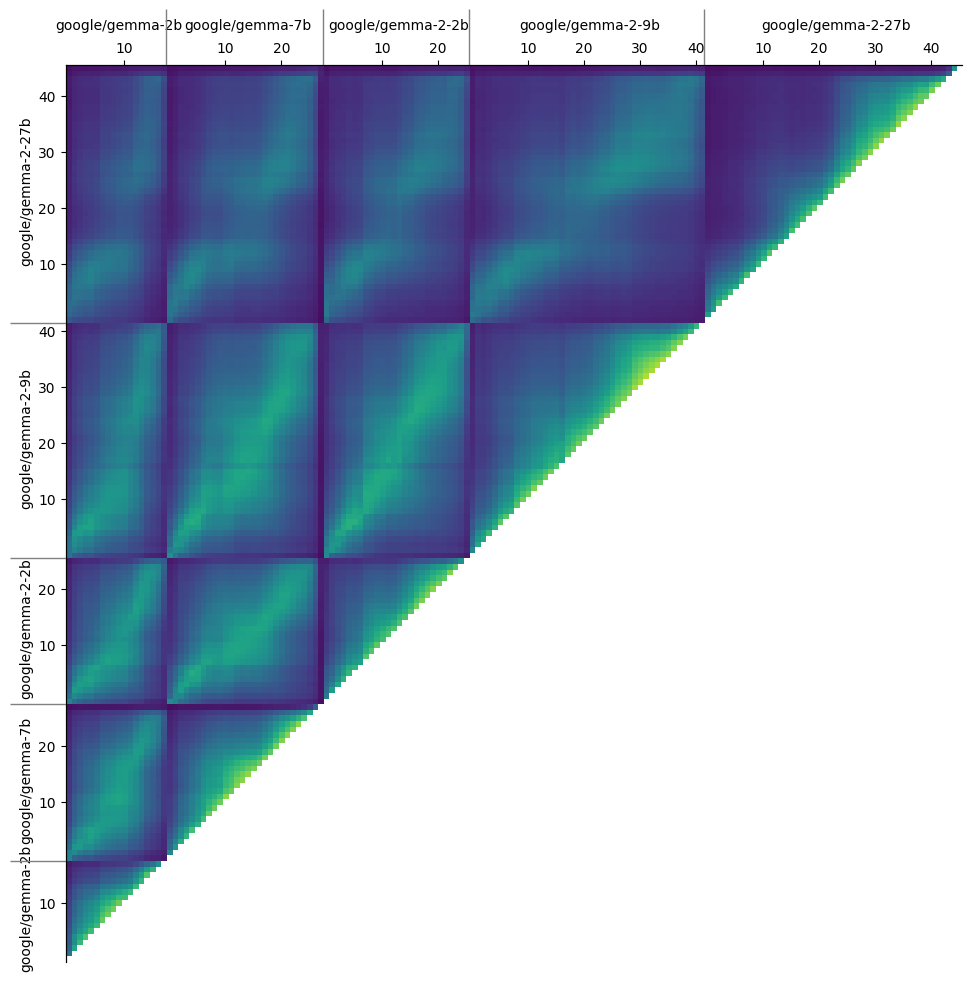

In [134]:
big_mat_plot(mknns, mat_model_names[:5], tick_spacing=10, invert_yaxis=True, rotate_model_names=False)
plt.tight_layout()
plt.show()

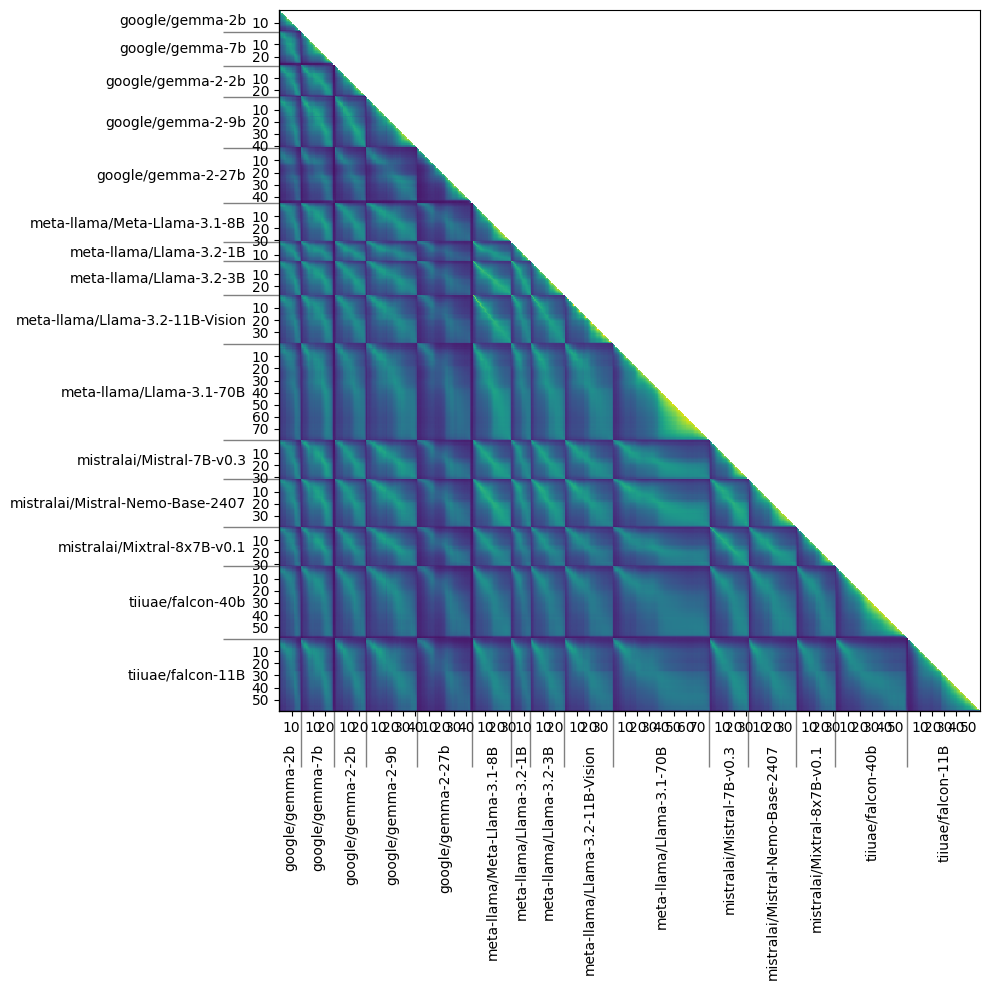

In [115]:
big_mat = torch.cat([torch.cat([get_from_all_mknn(mknns, m1, m2).T for m2 in mat_model_names]).T for m1 in mat_model_names])
big_mat = np.ma.array(big_mat, mask=np.tri(big_mat.shape[0], big_mat.shape[1], k=0).T)

model_layers = np.array([get_from_all_mknn(mknns, m, mat_model_names[0]).shape[0] for m in mat_model_names])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()

cax = ax.imshow(big_mat, vmin=0, vmax=1, interpolation="nearest", aspect='equal')
# fig.colorbar(cax, fraction=0.02)

# Layer ticks
tick_positions = np.array([])
tick_labels = np.array([], dtype=np.int64)
depth = 0
for d in model_layers:
    tick_positions = np.concatenate((tick_positions, np.arange(10, d, 10) + depth))
    tick_labels = np.concatenate((tick_labels, np.arange(10, d, 10)))
    depth += d

ax.xaxis.set_ticks(tick_positions, tick_labels)
ax.yaxis.set_ticks(tick_positions, tick_labels)

# Model ticks
model_tick_positions = model_layers.cumsum()
model_tick_positions = np.insert(model_tick_positions, 0, 0)
model_tick_positions = (model_tick_positions[1:] + model_tick_positions[:-1])/2

# sec = ax.secondary_xaxis(location='top')
sec = ax.secondary_xaxis(location=0)
sec.xaxis.set_ticks(model_tick_positions, mat_model_names)
sec.tick_params('x', length=20, width=0, rotation=90)

secy = ax.secondary_yaxis(location=0)
secy.yaxis.set_ticks(model_tick_positions, mat_model_names)
secy.tick_params('y', length=20, width=0, rotation=0)

for label in secy.get_yticklabels():
    label.set_verticalalignment('center')

# Seperators
seperator_positions = model_layers.cumsum()[:-1]

# sec2 = ax.secondary_xaxis(location='top')
sec2 = ax.secondary_xaxis(location=0)
sec2.xaxis.set_ticks(seperator_positions - 0.5, labels=[])
sec2.tick_params('x', length=40, width=1, colors='gray')

secy2 = ax.secondary_yaxis(location=0)
secy2.yaxis.set_ticks(seperator_positions - 0.5, labels=[])
secy2.tick_params('y', length=40, width=1, colors='gray')

# ax.xaxis.tick_top()
# ax.invert_yaxis()

plt.tight_layout()
plt.show()

### Experiments

In [10]:
def get_knn_path(model, dataset, use_chat_template=False):
    return os.path.join(project_dir, 'knn', unireps.get_dataset_name(model, dataset, use_chat_template=use_chat_template)) + '.parquet'

def get_layer_knn(model, dataset, use_chat_template=False, k=10):
    ds = datasets.Dataset.from_parquet(get_knn_path(model, dataset, use_chat_template=use_chat_template))
    ds.set_format('torch')
    return ds['knn'][:,:,:k].permute(1,0,2)

In [24]:
knn_1 = get_layer_knn('meta-llama/Llama-3.1-70B', 'web_text')
knn_2 = get_layer_knn("meta-llama/Meta-Llama-3.1-8B", 'web_text')

Generating train split: 0 examples [00:00, ? examples/s]

In [25]:
mknn = unireps.mutual_knn(knn_1, knn_2)

In [119]:
mat_model_names = [
    "openai-community/gpt2",
    "google/gemma-2b",
    "google/gemma-7b",
    "google/gemma-2-2b",
    "google/gemma-2-9b",
    "google/gemma-2-9b-it",
    "google/gemma-2-27b",
    "meta-llama/Meta-Llama-3.1-8B",
    "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "meta-llama/Llama-3.2-1B",
    "meta-llama/Llama-3.2-3B",
    "meta-llama/Llama-3.2-3B-Instruct",
    "meta-llama/Llama-3.2-11B-Vision",
    "meta-llama/Llama-3.1-70B",
    "meta-llama/Llama-3.1-70B-Instruct",
    "meta-llama/Llama-3.3-70B-Instruct",
    "mistralai/Mistral-7B-v0.3",
    "mistralai/Mistral-Nemo-Base-2407",
    "mistralai/Mixtral-8x7B-v0.1",
    "microsoft/Phi-3-mini-4k-instruct",
    "microsoft/Phi-3-medium-4k-instruct",
    "microsoft/Phi-3.5-mini-instruct",
    "tiiuae/falcon-40b",
    "tiiuae/falcon-11B",
    "tiiuae/falcon-mamba-7b"
]

In [9]:
def generate_all_mknn(model_names, dataset_name, init_mknns={}):
    model_knns = {}
    for m in tqdm(model_names):
        model_knns[m] = get_layer_knn(m, dataset_name)

    model_model_mknn = init_mknns
    for i in tqdm(range(len(model_names))):
        for j in range(i+1):
            m1 = model_names[i]
            m2 = model_names[j]

            if (m1,m2) in model_model_mknn or (m2,m1) in model_model_mknn:
                continue

            knn_1 = model_knns[m1]
            knn_2 = model_knns[m2]
            mknn = unireps.mutual_knn(knn_1, knn_2)

            model_model_mknn[(m1,m2)] = mknn

    return model_model_mknn

In [4]:
import pickle

In [6]:
with open(os.path.join(project_dir, 'mknn_backup.pickle'), 'rb') as f:
    mknns = pickle.load(f)

In [11]:
mknns = generate_all_mknn(model_names, 'web_text', init_mknns=mknns)

100%|██████████| 25/25 [2:11:25<00:00, 315.41s/it] 


In [12]:
import pickle
with open(os.path.join(project_dir, 'mknn_backup_2.pickle'), 'wb') as f:
    pickle.dump(mknns, f)

In [70]:
def get_from_all_mknn(mknns, m1, m2):
    if (m1,m2) in mknns:
        return mknns[(m1,m2)][1:,1:]
    else:
        return mknns[(m2,m1)][1:,1:].T

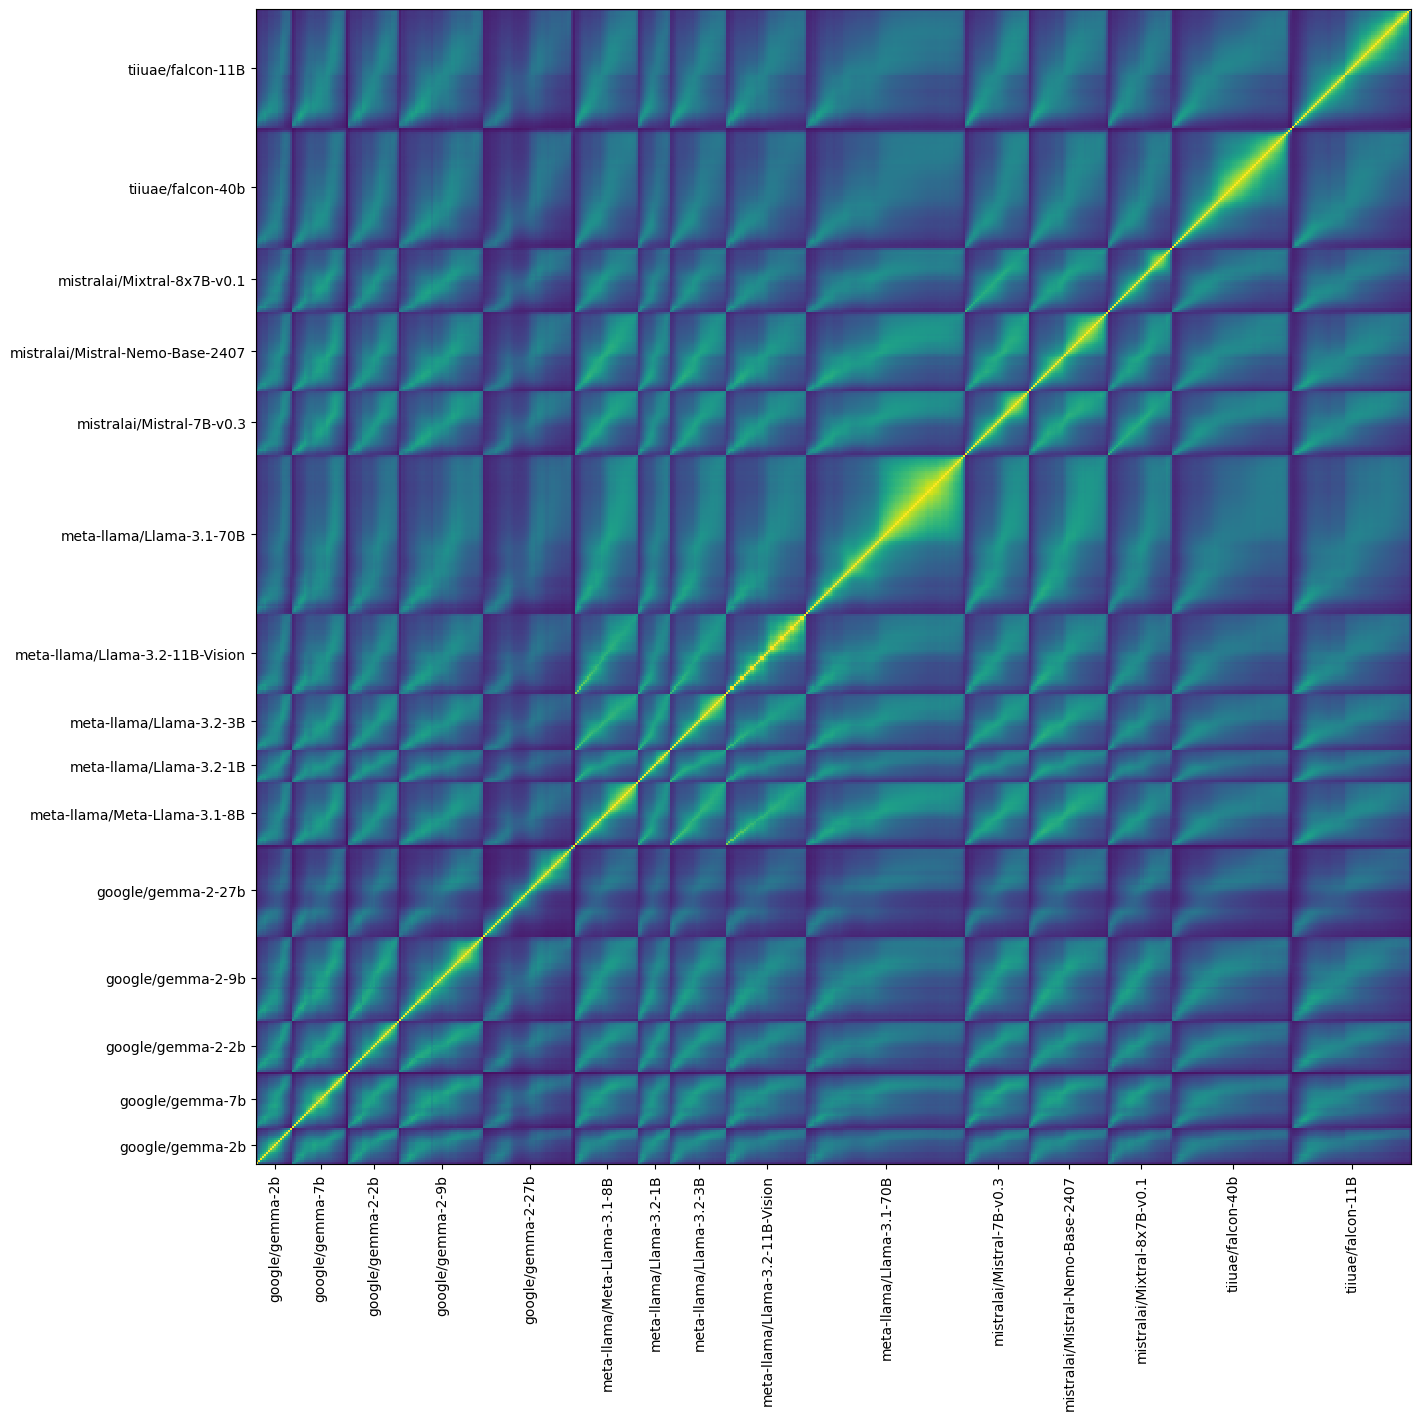

In [118]:
import numpy as np

big_mat = torch.cat([torch.cat([get_from_all_mknn(mknns, m1, m2).T for m2 in mat_model_names]).T for m1 in mat_model_names])
model_layers = np.array([get_from_all_mknn(mknns, m, mat_model_names[0]).shape[0] for m in mat_model_names])
tick_positions = model_layers.cumsum()
tick_positions = np.insert(tick_positions, 0, 0)
tick_positions = (tick_positions[1:] + tick_positions[:-1])/2

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot()

cax = ax.imshow(big_mat, vmin=0, vmax=1, interpolation="nearest", aspect='equal')
# fig.colorbar(cax, fraction=0.02)

ax.xaxis.set_tick_params(rotation=90)

ax.xaxis.set_ticks(tick_positions, mat_model_names)
ax.yaxis.set_ticks(tick_positions, mat_model_names)

ax.invert_yaxis()

plt.show()
# plt.savefig('./bigfig.pdf')

In [38]:
mknns.keys()

dict_keys([('google/gemma-7b', 'google/gemma-2b'), ('google/gemma-2-2b', 'google/gemma-2b'), ('google/gemma-2-2b', 'google/gemma-7b')])

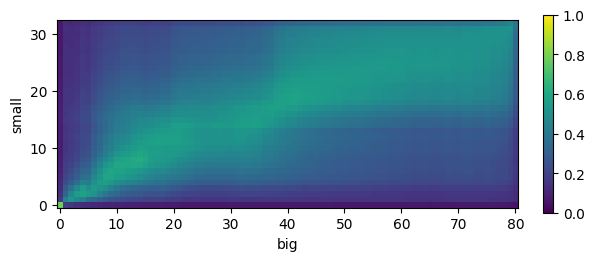

In [29]:
unireps.layer_by_layer_plot(mknn.T, x_label='big', y_label='small')
plt.show()

In [ ]:
unireps.mutual_knn_layer_plot('google/gemma-2-9b', )

In [11]:
unireps.dataset_embs(unireps.get_dataset('google/gemma-2-9b', 'web_text'), layer=None).flatten().shape[0]

315621376

In [10]:
unireps.dataset_embs(unireps.get_dataset('google/gemma-2-9b', 'web_text'), layer=None).dtype

torch.float32

In [6]:
unireps.get_dataset('google/gemma-2-9b', 'web_text')['at_max_length'].sum()

tensor(0)

In [3]:
ds1 = unireps.get_dataset('google/gemma-2-9b', 'web_text')
knn_1 = unireps.embs_knn(unireps.dataset_embs(ds1), k=10)

In [4]:
ds2 = unireps.get_dataset('meta-llama/Meta-Llama-3.1-8B', 'web_text')
knn_2 = unireps.embs_knn(unireps.dataset_embs(ds2), k=10)

In [5]:
unireps.mutual_knn(knn_1[10], knn_2[8])

0.513134777545929

In [9]:
unireps.mutual_knn(knn_1, knn_2[8])

tensor([0.0831, 0.1569, 0.2169, 0.2207, 0.2527, 0.2982, 0.3617, 0.3904, 0.4087,
        0.4865, 0.5131, 0.5304, 0.5674, 0.5695, 0.5682, 0.5576, 0.5491, 0.4960,
        0.4822, 0.4681, 0.4539, 0.4306, 0.4163, 0.4173, 0.4065, 0.4018, 0.3722,
        0.3597, 0.3581, 0.3388, 0.3110, 0.2991, 0.2825, 0.2692, 0.2590, 0.2489,
        0.2453, 0.2361, 0.2302, 0.2268, 0.2138, 0.1868, 0.1689])

In [12]:
unireps.mutual_knn(knn_1[10], knn_2)

tensor([0.1092, 0.2494, 0.3223, 0.3869, 0.4757, 0.5337, 0.5438, 0.5401, 0.5131,
        0.4736, 0.4534, 0.4272, 0.4141, 0.3963, 0.3869, 0.3910, 0.3804, 0.3634,
        0.3356, 0.3242, 0.3117, 0.2981, 0.2833, 0.2706, 0.2563, 0.2474, 0.2460,
        0.2348, 0.2316, 0.2263, 0.2199, 0.2164, 0.1877])

In [15]:
a = unireps.mutual_knn(knn_1, knn_2)
a

tensor([[0.8828, 0.1515, 0.1325,  ..., 0.0655, 0.0663, 0.0607],
        [0.1518, 0.3474, 0.3457,  ..., 0.1095, 0.1116, 0.1003],
        [0.1511, 0.4600, 0.4422,  ..., 0.1699, 0.1732, 0.1602],
        ...,
        [0.0558, 0.1285, 0.1358,  ..., 0.4652, 0.4524, 0.3684],
        [0.0531, 0.1179, 0.1220,  ..., 0.4315, 0.4288, 0.3586],
        [0.0484, 0.1097, 0.1110,  ..., 0.3744, 0.3758, 0.3248]])

In [16]:
a[10,8]

tensor(0.5131)

In [2]:
embs_1 = unireps.dataset_embs(unireps.get_dataset('google/gemma-2-9b', 'web_text'), layer=None)

In [3]:
knn = unireps.embs_knn(embs_1, k=10)

In [5]:
knn_1 = unireps.embs_knn(embs_1[0], k=10)

In [10]:
knn[0] == knn_1

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [4]:
knn.shape

torch.Size([43, 2048, 10])

In [6]:
knn_1.shape

torch.Size([2048, 10])

In [7]:
embs_1.shape

torch.Size([43, 2048, 3584])

In [14]:
knn.dim()

3

In [11]:
emb_2 = unireps.dataset_embs(ds2)

NameError: name 'ds2' is not defined

In [ ]:
knn_2 = unireps.embs_knn(unireps.dataset_embs(ds2), k=10)

In [27]:
ds1 = unireps.get_dataset('google/gemma-2-9b', 'web_text')
emb_1 = unireps.dataset_embs(ds1)

In [28]:
emb_1 = unireps.dataset_embs(ds1)

In [35]:
emb_1[0] @ emb_1[0].T

tensor([[ 1.0000,  0.2438,  0.0247,  ...,  0.1147,  0.2438,  0.1630],
        [ 0.2438,  1.0000, -0.1881,  ..., -0.0142,  1.0000,  0.5315],
        [ 0.0247, -0.1881,  1.0000,  ...,  0.2875, -0.1881, -0.0791],
        ...,
        [ 0.1147, -0.0142,  0.2875,  ...,  1.0000, -0.0142,  0.0527],
        [ 0.2438,  1.0000, -0.1881,  ..., -0.0142,  1.0000,  0.5315],
        [ 0.1630,  0.5315, -0.0791,  ...,  0.0527,  0.5315,  1.0000]])

In [31]:
unireps.embs_knn(emb_1, k=10)

tensor([[[1793, 1326, 2023,  ..., 1980,  852,  671],
         [  44,   36,   48,  ...,   43,   35,   32],
         [1029, 1998,  909,  ...,  732, 1691,  391],
         ...,
         [1582, 1706, 1677,  ...,  391, 1729, 1691],
         [   5,    4,   15,  ...,   17,   13,    3],
         [ 574,  328,  604,  ...,  573,  396,  324]],

        [[1793, 1326, 2023,  ..., 1689, 1323, 1707],
         [1869,  673,  931,  ...,  448,  765, 1817],
         [ 731,  337,  939,  ..., 1726, 1390, 1643],
         ...,
         [1932,  271, 1884,  ..., 1563,  211, 1342],
         [ 491,  458, 1278,  ..., 1432, 1752, 1133],
         [1295,  604,  215,  ...,  574,  328, 1739]],

        [[1793, 1160, 1257,  ...,  912, 1258, 1252],
         [1581,  673, 1824,  ...,  753,  832,  993],
         [ 854, 1029,  329,  ..., 1102, 1368, 1165],
         ...,
         [1884, 1932,  271,  ...,   16, 1691, 1141],
         [ 491, 1432, 1752,  ..., 1133,  181,  425],
         [1295,  396,  604,  ..., 1925,  328,  574]],

In [16]:
knn_1 = unireps.embs_knn(emb_1, k=10)

In [9]:
knn_1 = model_dataset_knn("google/gemma-2-9b", "web_text")
knn_2 = model_dataset_knn("google/gemma-2-9b-it", "web_text")

In [10]:
mknn = unireps.mutual_knn(knn_1, knn_2)

In [37]:
ds1 = unireps.get_dataset('google/gemma-2-9b', 'web_text')
emb_1 = unireps.dataset_embs(ds1)

ds2 = unireps.get_dataset('google/gemma-2-9b-it', 'web_text')
emb_2 = unireps.dataset_embs(ds2)

In [6]:
def rv(x, y):
    gramX = x @ x.T
    gramY = y @ y.T
    
    return torch.linalg.matrix_norm(gramX.T @ gramY)**2 / (torch.linalg.matrix_norm(gramX.T @ gramX) * torch.linalg.matrix_norm(gramY.T @ gramY))

In [7]:
from tqdm import tqdm

In [53]:
rvs = torch.zeros(len(emb_1), len(emb_2))
for i, x in enumerate(tqdm(emb_1)):
    for j, y in enumerate(emb_2):
        rvs[i, j] = rv(x, y)

100%|██████████| 43/43 [04:03<00:00,  5.66s/it]


In [54]:
rvs

tensor([[1.0005, 0.9734, 0.9702,  ..., 0.8192, 0.8080, 0.8245],
        [0.9724, 0.9998, 0.9977,  ..., 0.9041, 0.8945, 0.9065],
        [0.9717, 0.9981, 0.9997,  ..., 0.8989, 0.8884, 0.9032],
        ...,
        [0.8271, 0.8972, 0.8979,  ..., 0.9964, 0.9947, 0.9819],
        [0.8103, 0.8818, 0.8817,  ..., 0.9951, 0.9961, 0.9814],
        [0.8397, 0.9048, 0.9073,  ..., 0.9557, 0.9483, 0.9630]])

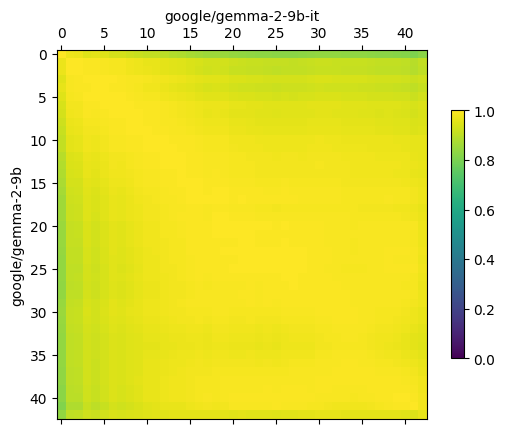

In [59]:
unireps.layer_by_layer_plot(rvs, model_1="google/gemma-2-9b", model_2="google/gemma-2-9b-it")
plt.show()

In [5]:
ds1 = unireps.get_dataset('google/gemma-2-9b', 'web_text')
emb_1 = unireps.dataset_embs(ds1)

ds2 = unireps.get_dataset("meta-llama/Meta-Llama-3.1-8B", 'web_text')
emb_2 = unireps.dataset_embs(ds2)

In [8]:
rvs = torch.zeros(len(emb_1), len(emb_2))
for i, x in enumerate(tqdm(emb_1)):
    for j, y in enumerate(emb_2):
        rvs[i, j] = rv(x, y)

100%|██████████| 43/43 [04:17<00:00,  5.99s/it]


In [38]:
self_ckas = torch.zeros(len(emb_2), len(emb_2))
for i, x in enumerate(tqdm(emb_2)):
    for j, y in enumerate(emb_2):
        self_ckas[i, j] = cka(x, y)

100%|██████████| 33/33 [05:40<00:00, 10.32s/it]


In [25]:
ckas = torch.zeros(len(emb_1), len(emb_2))
for i, x in enumerate(tqdm(emb_1)):
    for j, y in enumerate(emb_2):
        ckas[i, j] = cka(x, y)

100%|██████████| 43/43 [07:17<00:00, 10.18s/it]


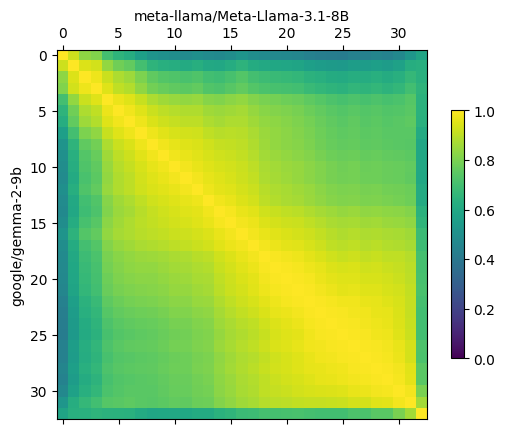

In [39]:
unireps.layer_by_layer_plot(self_ckas, model_1="google/gemma-2-9b", model_2="meta-llama/Meta-Llama-3.1-8B")
plt.show()

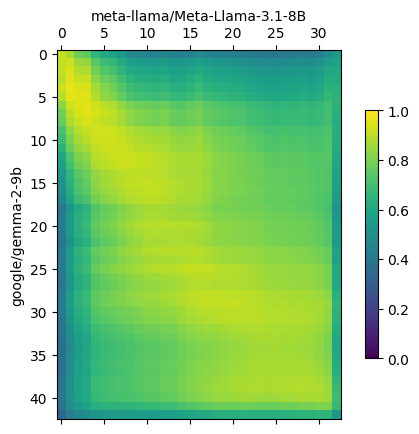

In [34]:
unireps.layer_by_layer_plot(ckas, model_1="google/gemma-2-9b", model_2="meta-llama/Meta-Llama-3.1-8B")
plt.show()

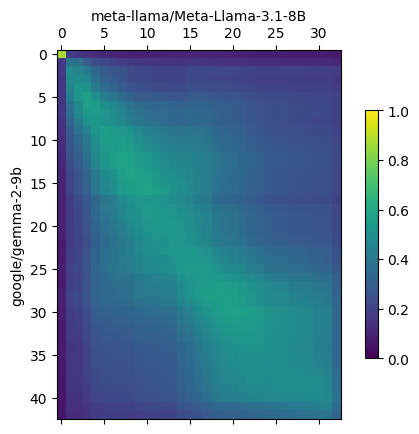

In [30]:
knn_1 = model_dataset_knn("meta-llama/Meta-Llama-3.1-8B", "web_text")
knn_2 = model_dataset_knn("google/gemma-2-9b", "web_text")
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn.T, model_1="google/gemma-2-9b", model_2="meta-llama/Meta-Llama-3.1-8B")
plt.show()

In [86]:
def cka(feats_A, feats_B, kernel_metric='ip', rbf_sigma=1.0, unbiased=False):
        """Computes the unbiased Centered Kernel Alignment (CKA) between features."""
        
        if kernel_metric == 'ip':
            # Compute kernel matrices for the linear case
            K = torch.mm(feats_A, feats_A.T)
            L = torch.mm(feats_B, feats_B.T)
        elif kernel_metric == 'rbf':
            # COMPUTES RBF KERNEL
            K = torch.exp(-torch.cdist(feats_A, feats_A) ** 2 / (2 * rbf_sigma ** 2))
            L = torch.exp(-torch.cdist(feats_B, feats_B) ** 2 / (2 * rbf_sigma ** 2))
        else:
            raise ValueError(f"Invalid kernel metric {kernel_metric}")

        # Compute HSIC values
        hsic_fn = hsic_unbiased if unbiased else hsic_biased
        hsic_kk = hsic_fn(K, K)
        hsic_ll = hsic_fn(L, L)
        hsic_kl = hsic_fn(K, L)

        # Compute CKA
        #print('hsic', hsic_kl)
        cka_value = hsic_kl / (torch.sqrt(hsic_kk * hsic_ll) + 1e-6)        
        return cka_value.item()

def hsic_biased(K, L):
    """ Compute the biased HSIC (the original CKA) """
    H = torch.eye(K.shape[0], dtype=K.dtype, device=K.device) - 1 / K.shape[0]
    return torch.trace(K @ H @ L @ H)

def hsic_unbiased(K, L):
    """
    Compute the unbiased Hilbert-Schmidt Independence Criterion (HSIC) as per Equation 5 in the paper.
    > Reference: https://jmlr.csail.mit.edu/papers/volume13/song12a/song12a.pdf
    """
    m = K.shape[0]

    # Zero out the diagonal elements of K and L
    K_tilde = K.clone().fill_diagonal_(0)
    L_tilde = L.clone().fill_diagonal_(0)

    # Compute HSIC using the formula in Equation 5
    HSIC_value = (
        (torch.sum(K_tilde * L_tilde.T))
        + (torch.sum(K_tilde) * torch.sum(L_tilde) / ((m - 1) * (m - 2)))
        - (2 * torch.sum(torch.mm(K_tilde, L_tilde)) / (m - 2))
    )

    HSIC_value /= m * (m - 3)
    return HSIC_value

In [9]:
mmlu = datasets.load_dataset('TIGER-Lab/MMLU-Pro', split='test')

README.md:   0%|          | 0.00/10.9k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/4.15M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/45.3k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/12032 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/70 [00:00<?, ? examples/s]

In [13]:
mmlu

Dataset({
    features: ['question_id', 'question', 'options', 'answer', 'answer_index', 'cot_content', 'category', 'src'],
    num_rows: 12032
})

In [24]:
mmlu.shuffle(seed=1234)[0]

{'question_id': 4838,
 'question': "The significance of Frere's discovery was that what he found was located:",
 'options': ['inside a previously undiscovered pyramid.',
  'in the depths of the ocean, near the remains of a sunken ship.',
  'on a remote island, far from known human settlements.',
  'on the surface, above the remains of extinct animals.',
  'beneath the remains of extinct animals.',
  'in a region of Africa where no one thought humans had ever lived.',
  'on top of the ruins of a Medieval castle.',
  'in the heart of a bustling modern city, underneath a skyscraper.',
  'within the remnants of a prehistoric cave dwelling.',
  'in a place where only dinosaur fossils had been found.'],
 'answer': 'E',
 'answer_index': 4,
 'cot_content': '',
 'category': 'history',
 'src': 'ori_mmlu-prehistory'}

In [21]:
for t in mmlu.select_columns('question').rename_column('question', 'text').shuffle(seed=1234).take(2048)['text']:
    print(t)
    print("#####")

The significance of Frere's discovery was that what he found was located:
#####
In Bandura's social learning theory, the concept of seif-reinforcement is critical for explaining how in the absence of external reward
#####
The normal boiling point of water is 9720 cal/mole. Calculate the heat of vaporization at 35°C and 1 atm. Use thefollowing C_p values to solve the problem. C_p Values forH_2O(1); C_p = 18.06 cal deg^-1 mole^-1 (independentof temperature) forH_2O(g); C_p = 7.219 + 2.374(10^-3)T + 2.67(10^-7)T^2 caldeg^-1 mole^-1
#####
Mr. Patrick is preparing a five-question true-false quiz for his class. He flips a coin before writing the first question. If it is heads, he writes a true statement and if it is tails, he writes a false statement. He continues this until all five statements are written. What is the probability that the correct sequence of answers is TFTFT ? Express your answer as a common fraction.
#####
While driving to school, Elise hears about a concert ticket giveawa

In [28]:
model_dataset_knn("google/gemma-2-9b", "TIGER-Lab/MMLU-Pro")

Dataset({
    features: ['question_id', 'question', 'options', 'answer', 'answer_index', 'cot_content', 'category', 'src'],
    num_rows: 12032
})

In [68]:
ds = unireps.get_dataset('meta-llama/Llama-3.1-70B-Instruct', 'web_text', use_chat_template=False)

Loading dataset from disk:   0%|          | 0/22 [00:00<?, ?it/s]

In [69]:
embs = unireps.dataset_embs(ds, layer=None, agg='last', normalize=True)

In [31]:
knn = unireps.embs_knn(embs, k=10)

In [71]:
def knn_mat(emb_mat):
    gram = emb_mat @ emb_mat.T
    gram.fill_diagonal_(-torch.inf)
    nn = gram.argsort(descending=True)[:, :gram.shape[0]-1]
    return nn

In [85]:
datasets.Dataset.from_dict({'text': ds['text'], 'knn': torch.stack([knn_mat(e) for e in embs]).permute(1,0,2).to(torch.int16), 'at_max_length': ds['at_max_length']}).to_parquet('/Users/christopher/Downloads/test.parquet')

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

687028806

In [76]:
torch.stack([knn_mat(e) for e in embs]).permute(1,0,2).shape

torch.Size([2048, 81, 2047])

In [70]:
gram = emb_mat @ emb_mat.T
gram.fill_diagonal_(-torch.inf)
nn = gram.argsort(descending=True)[:, :gram.shape[0]-1]
nn.to(torch.int16)

tensor([[1793, 1421, 2005,  ...,  856,  143,  104],
        [ 673, 2040,  292,  ...,   20,  419, 1436],
        [ 854, 1879, 1026,  ..., 1722, 1955, 1904],
        ...,
        [1035,  507,  698,  ..., 1012,  633,  743],
        [1711,  647, 1058,  ..., 1582,  419, 1212],
        [1756,  604, 1198,  ..., 1582,  314, 1072]], dtype=torch.int16)

In [48]:
gram.topk(6, sorted=True).indices

tensor([[1793, 1421, 2005,  919,  780,  990],
        [ 673, 2040,  292, 1367,  138,  963],
        [ 854, 1879, 1026,  135, 1870, 1938],
        ...,
        [1035,  507,  698, 2022,  773, 1192],
        [1711,  647, 1058, 1519,  432,   63],
        [1756,  604, 1198,  574,  221,  774]])

In [51]:
gram.argsort(descending=True)

tensor([[1793, 1421, 2005,  ...,  143,  104,    0],
        [ 673, 2040,  292,  ...,  419, 1436,    1],
        [ 854, 1879, 1026,  ..., 1955, 1904,    2],
        ...,
        [1035,  507,  698,  ...,  633,  743, 2045],
        [1711,  647, 1058,  ...,  419, 1212, 2046],
        [1756,  604, 1198,  ...,  314, 1072, 2047]])